## Extracting SIFT points for all images

In [1]:
# loading the metadata
%load_ext autoreload
%autoreload 2

import pandas as pd
import cv2 
import matplotlib.pyplot as plt
%matplotlib inline

from torch import nn
import torchvision.models as models
from tqdm import tqdm
import torch
import pickle
from glob import glob
from scipy import sparse


from utils import *

path = '/home/guhennec/scratch/2021_Cini/TopologicalAnalysis_Cini/data/'
data_dir = '/scratch/students/schaerf/'
replica_dir = '/mnt/project_replica/datasets/cini/'


In [2]:
data = pd.read_csv(data_dir + 'dedup_data_sample.csv')
data.shape

(12862, 49)

18331


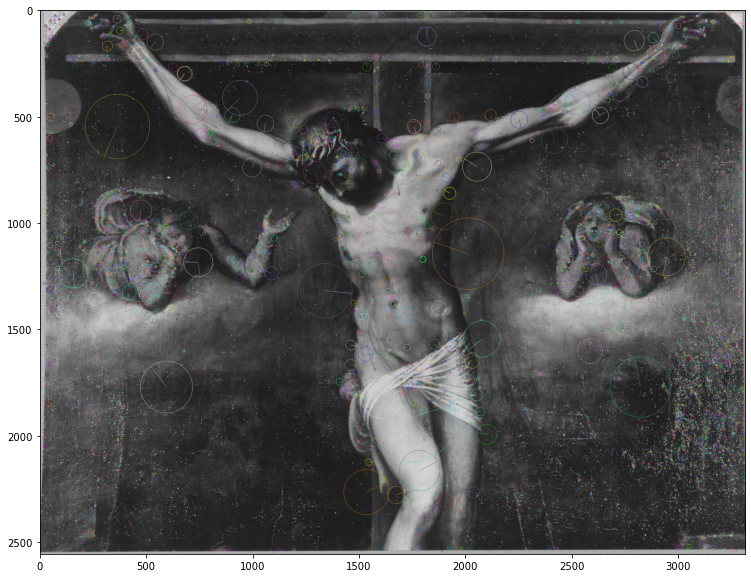

In [3]:
#reading image
img = cv2.imread(replica_dir + data.sample()['path'].values[0])  

#keypoints
gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
sift = cv2.SIFT_create()
kp = sift.detect(gray,None)
print(len(kp))
img=cv2.drawKeypoints(gray,kp,img, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

fig, ax = plt.subplots(1,1, figsize=(20,10))
plt.imshow(img)


In [4]:
train = pd.read_csv(data_dir + 'dataset/abc_train_100.csv')
train

,Unnamed: 0,index,A,B,C,set,A_path,B_path,C_path
0,0,5,06d37d5e06ce4b40b583c1cb6d7f68b2,b91c9e7b758249bfaa60046166560783,7af27cf8d2144f328e6fc5561c6ee213,train,157A/157A_49.jpg,158C/158C_213.jpg,156C/156C_231.jpg
1,1,5,06d37d5e06ce4b40b583c1cb6d7f68b2,b91c9e7b758249bfaa60046166560783,7918588e8a5e432b876915a0cd6894d7,train,157A/157A_49.jpg,158C/158C_213.jpg,71B/71B_43.jpg
2,2,5,06d37d5e06ce4b40b583c1cb6d7f68b2,b91c9e7b758249bfaa60046166560783,fe4fda9cacb94efe8da17aac33d8b6e4,train,157A/157A_49.jpg,158C/158C_213.jpg,121B/121B_575.jpg
3,3,5,06d37d5e06ce4b40b583c1cb6d7f68b2,b91c9e7b758249bfaa60046166560783,3879662544c94e91ad3b653cbe959db3,train,157A/157A_49.jpg,158C/158C_213.jpg,71B/71B_38.jpg
4,4,5,06d37d5e06ce4b40b583c1cb6d7f68b2,b91c9e7b758249bfaa60046166560783,30e42264670744019db1c1ba59ff3032,train,157A/157A_49.jpg,158C/158C_213.jpg,113C/113C_274.jpg
...,...,...,...,...,...,...,...,...,...
8761,8761,2858,a7d5691e942b4f439f4fbe15679a95a8,111f79c1ec1f4bfeb70b209d98204b4d,066c36f2a35f4ba583e7796a212203f1,train,53C/53C_256.jpg,47A/47A_824.jpg,57A/57A_868.jpg
8762,8762,2858,a7d5691e942b4f439f4fbe15679a95a8,111f79c1ec1f4bfeb70b209d98204b4d,5a46938b14bc41578444622568d16e5f,train,53C/53C_256.jpg,47A/47A_824.jpg,50C/50C_810.jpg
8763,8763,2858,a7d5691e942b4f439f4fbe15679a95a8,111f79c1ec1f4bfeb70b209d98204b4d,11e637725f7b448dae0e9b5759fa0850,train,53C/53C_256.jpg,47A/47A_824.jpg,97B/97B_537.jpg
8764,8764,2858,a7d5691e942b4f439f4fbe15679a95a8,111f79c1ec1f4bfeb70b209d98204b4d,addc1a1842f14f43b10dc2b5ef78aea3,train,53C/53C_256.jpg,47A/47A_824.jpg,160A/160A_451.jpg


284 782


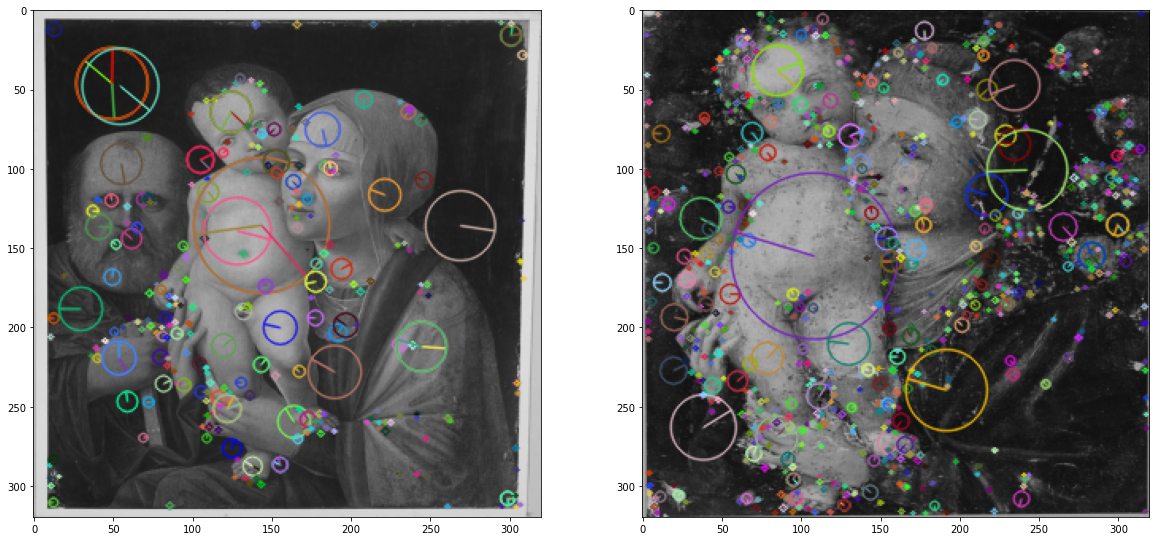

In [7]:
sample = train.sample()
img1 = cv2.imread(replica_dir + sample['A_path'].values[0]) 
img1 = cv2.resize(img1, (320,320), interpolation = cv2.INTER_AREA)
img2 = cv2.imread(replica_dir + sample['B_path'].values[0])  
img2 = cv2.resize(img2, (320,320), interpolation = cv2.INTER_AREA)

#keypoints
gray1 = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)

kp1, des1 = sift.detectAndCompute(gray1,None)
kp2, des2 = sift.detectAndCompute(gray2,None)

print(len(kp1), len(kp2))

img1=cv2.drawKeypoints(gray1,kp1,img1, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img2=cv2.drawKeypoints(gray2,kp2,img2, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

fig, axs = plt.subplots(1,2, figsize=(20,10))
axs[0].imshow(img1)
axs[1].imshow(img2)


120


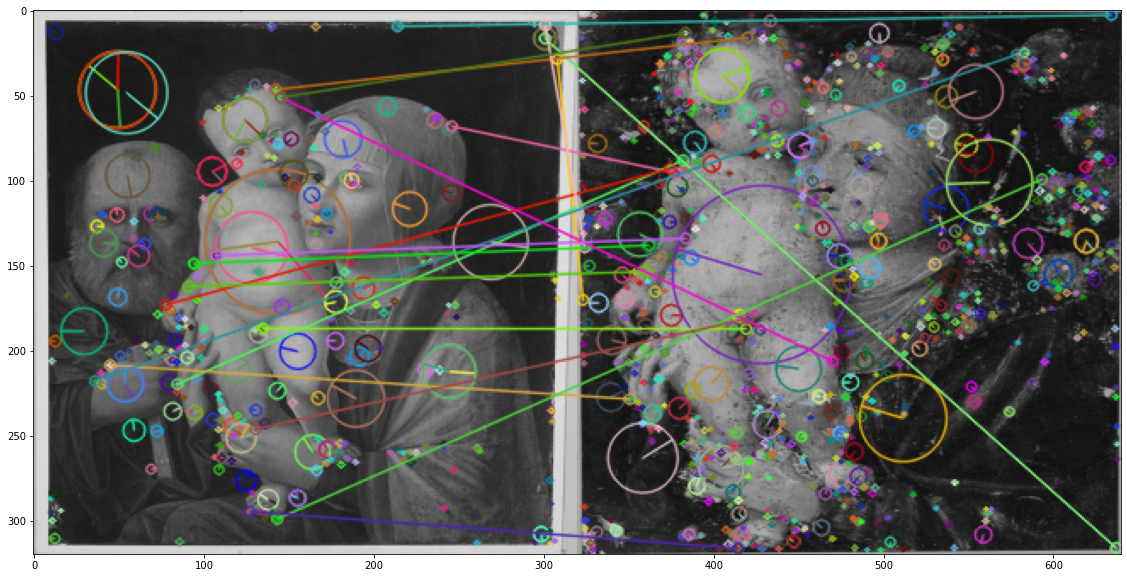

(<matplotlib.image.AxesImage at 0x7f48713667f0>, None)

In [8]:
#feature matching
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

matches = bf.match(des1,des2)
matches = sorted(matches, key = lambda x:x.distance)

print(len(matches))
img3 = cv2.drawMatches(img1, kp1, img2, kp2, matches[:20], img2, flags=2, matchesThickness = 1)
fig, axs = plt.subplots(1,1, figsize=(20,10))
plt.imshow(img3),plt.show()

In [9]:
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)

In [10]:
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)


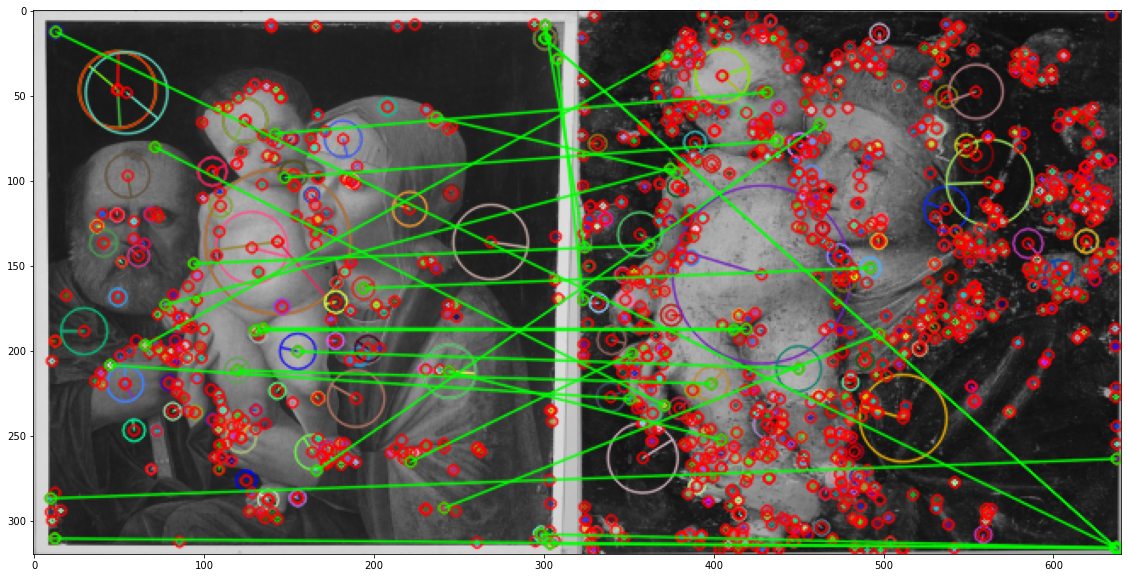

(<matplotlib.image.AxesImage at 0x7f4871220520>, None)

In [13]:

# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in range(len(matches))]

# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        matchesMask[i]=[1,0]

draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   #matchesThickness = 3,
                   matchesMask = matchesMask,
                   flags = cv2.DrawMatchesFlags_DEFAULT)

img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,matches,None,**draw_params)
fig, axs = plt.subplots(1,1, figsize=(20,10))
plt.imshow(img3,),plt.show()

In [27]:
from scipy.spatial import distance
from sklearn.linear_model import RANSACRegressor

def get_candidates(des1, des2, kp1, kp2, norm_epsilon=0, margin=1, crosscheck_limit=2): #f_map_1, f_map_2, 
    # normalize(f_map_1, norm_epsilon)
    # normalize(f_map_2, norm_epsilon)

    # h1, w1, d_size = f_map_1.shape

    # h2, w2, _ = f_map_2.shape
    # # Convert to descriptors, keypoint versions
    # des1 = np.ascontiguousarray(f_map_1[margin:h1 - margin, margin:w1 - margin]).reshape((-1, d_size))
    # des2 = np.ascontiguousarray(f_map_2[margin:h2 - margin, margin:w2 - margin]).reshape((-1, d_size))
    # kp1 = (nb_unravel_array(np.arange(len(des1)), (h1 - 2 * margin, w1 - 2 * margin)) + 0.5 + margin).astype(np.float32)
    # kp2 = (nb_unravel_array(np.arange(len(des2)), (h2 - 2 * margin, w2 - 2 * margin)) + 0.5 + margin).astype(np.float32)
    # # Because of the margin, the arrays might be empty
    if len(kp1) == 0 or len(kp2) == 0:
        return np.empty((0, 2), np.float32), np.empty((0, 2), np.float32),  np.empty((0,), np.float32)
    # d = distance.cdist(des1, des2)
    d = 1 - des1 @ des2.T  # Warning, that is ~1/2 of the euclidean distance since des1.norm ~ des2.norm ~ 1
    best_1 = np.empty((len(d), crosscheck_limit), dtype=np.int32)
    for i in range(len(d)):
        best_1[i, :] = np.argsort(d[i, :])[:crosscheck_limit]
    d_T = d.T
    best_2 = np.empty((len(d_T), crosscheck_limit), dtype=np.int32)
    for i in range(len(d_T)):
        best_2[i, :] = np.argsort(d_T[i, :])[:crosscheck_limit]

    # best_1 = np.argsort(d, axis=1)[:, :crosscheck_limit]
    # best_2 = np.argsort(d.T, axis=1)[:, :crosscheck_limit]
    best_1_o = [set(best_1[i, :]) for i in range(len(best_1))]
    best_2_o = [set(best_2[i, :]) for i in range(len(best_2))]
    # d = des1 @ des2.T
    # best_1 = np.argmax(d, axis=1)
    # best_2 = np.argmax(d, axis=0)
    good = np.array([(i, j) for i, s in enumerate(best_1_o) for j in s if i in best_2_o[j]])
    print(good[:, 0])
    print(kp1[0].pt)
    src_pts = kp1[good[:, 0]]
    dst_pts = kp2[good[:, 1]]
    distances = np.array([d[good[i, 0], good[i, 1]] for i in range(len(good))])
    return src_pts, dst_pts, distances


In [28]:
get_candidates(des1, des2, kp1, kp2)

[  4   5   5   6   6   7   8   9  10  11  12  14  15  15  17  18  18  20
  22  24  24  25  25  26  28  28  29  29  30  31  31  35  35  36  37  37
  39  39  42  42  43  44  46  46  47  47  48  49  49  50  50  51  52  53
  54  55  58  58  59  59  60  60  62  62  65  65  66  67  67  68  69  70
  71  72  72  73  74  74  75  75  76  77  77  78  79  79  81  81  83  83
  84  84  85  86  86  87  87  88  88  92  93  93  94  95  95  96  97  98
  99 100 100 101 102 102 104 105 105 106 107 107 108 108 111 112 113 114
 114 115 116 116 117 117 119 120 121 121 122 123 124 125 125 126 127 127
 129 130 130 131 131 132 132 134 136 137 137 138 138 141 142 143 144 145
 145 146 147 147 148 148 149 149 150 151 151 152 152 153 153 154 155 156
 157 158 158 159 162 162 163 163 164 165 165 166 167 168 168 169 170 170
 171 171 172 174 174 176 176 177 178 178 179 179 181 181 182 182 183 184
 184 185 185 186 186 187 187 188 188 189 189 190 190 191 192 192 193 193
 194 195 195 196 196 197 197 199 200 201 201 203 20

TypeError: only integer scalar arrays can be converted to a scalar index

In [32]:
des1[0], kp1[0].pt, kp1[0].size, kp1[0].angle

(array([ 50.,  55.,  16.,   8.,   1.,   1.,   2.,  11.,  71.,  17.,  25.,
         39.,   6.,   7.,   4.,   5., 197.,   4.,   1.,   1.,   0.,   1.,
          1.,  16.,  45.,   0.,   0.,   0.,   3.,   1.,   0.,   3.,   7.,
         65.,  14.,   1.,   0.,   0.,   0.,   0., 117.,  69.,  25.,   5.,
          0.,   0.,   0.,   1., 197.,  17.,   0.,   0.,   0.,   0.,   0.,
          7.,  54.,   0.,   0.,   0.,   5.,   0.,   0.,   2.,   2.,  14.,
          3.,   0.,   0.,   0.,   0.,   0., 175.,  33.,   6.,   0.,   0.,
          0.,   0.,   2., 197.,   6.,   0.,   0.,   0.,   0.,   0.,  12.,
         52.,   0.,   0.,   0.,   5.,   0.,   0.,   2.,   1.,   2.,   1.,
          0.,   0.,   0.,   0.,   0., 167.,   3.,   0.,   0.,   0.,   0.,
          0.,   5., 197.,   0.,   0.,   0.,   0.,   0.,   0.,  15.,  37.,
          0.,   0.,   0.,   5.,   0.,   0.,   2.], dtype=float32),
 (10.070148468017578, 286.8363952636719),
 2.022474527359009,
 178.9189453125)

In [ ]:
def spatially_coherent_mask(src_pts, dst_pts, residual_threshold=2.0):
    min_x0_y0, increment_x0_y0 = -15, 1
    max_x0_y0 = -min_x0_y0
    possible_x0 = np.arange(min_x0_y0, max_x0_y0, increment_x0_y0, np.int32)
    possible_y0 = np.arange(min_x0_y0, max_x0_y0, increment_x0_y0, np.int32)
    possible_lambdas = np.exp(np.arange(-7, 7)*0.2)  # ln(4) ~ 1.4 so 0.25-4x zoom
    possible_params = np.zeros((len(possible_x0), len(possible_y0), len(possible_lambdas), 2))
    for i in range(len(src_pts)):
        src_y, src_x = src_pts[i]
        dst_y, dst_x = dst_pts[i]
        for i_lamb, lamb in enumerate(possible_lambdas):
            x0 = dst_x-lamb*src_x
            y0 = dst_y-lamb*src_y
            i_x0 = int(round((x0-min_x0_y0)/increment_x0_y0))
            i_y0 = int(round((y0-min_x0_y0)/increment_x0_y0))
            if 0 <= i_x0 < len(possible_x0) and 0 <= i_y0 < len(possible_y0):
                possible_params[i_x0, i_y0, i_lamb, 0] += 1

            # Flip
            x0 = dst_x+lamb*src_x
            i_x0 = int(round((x0-min_x0_y0)/increment_x0_y0))
            if 0 <= i_x0 < len(possible_x0) and 0 <= i_y0 < len(possible_y0):
                possible_params[i_x0, i_y0, i_lamb, 1] += 1

    best_inds = np.argsort(possible_params.ravel())[-5:]
    best_inliers = 0
    best_mask = np.full(len(src_pts), False, dtype=np.bool_)
    best_M = np.array([
                [1, 0],
                [0, 1],
                [0, 0]
            ], dtype=np.float32)
    mask = best_mask.copy()
    preds = np.empty((1, 2), dtype=np.float32)
    src_pts_intercept = np.concatenate((src_pts, np.ones((len(src_pts), 1), dtype=np.float32)), axis=1)
    for ind in best_inds:
        i_x0, i_y0, i_lamb, is_flipped = nb_unravel(ind, dims=possible_params.shape)
        x0 = possible_x0[i_x0]
        y0 = possible_y0[i_y0]
        lamb = possible_lambdas[i_lamb]

        M = np.array([
                [lamb, 0],
                [0, (1-2*int(is_flipped))*lamb],
                [y0, x0]
            ], dtype=np.float32)
        preds = src_pts_intercept @ M
        mask = np.sum(np.square(preds-dst_pts), axis=1) <= residual_threshold
        if np.sum(mask) > best_inliers:
            best_inliers = np.sum(mask)
            best_mask[:] = mask
            best_M = M

    assert np.sum(best_mask) == best_inliers, "weird"

    if best_inliers > 0:
        assert np.sum(best_mask) > 0, "weird2"
        # Refine matrix
        #M, _, _, _ = np.linalg.lstsq(np.concatenate([src_pts[best_mask], np.ones((np.sum(best_mask), 1))], axis=1),
        #                             dst_pts[best_mask], rcond=-1)
        return best_M, best_mask
    else:
        print("No inliers?")
        return best_M, best_mask


def match_feature_maps(f_map_1, f_map_2, norm_epsilon=0, margin=1, crosscheck_limit=3):
    with Timer("candidates", disable=True):
        src_pts, dst_pts, distances = get_candidates(f_map_1, f_map_2, norm_epsilon, margin, crosscheck_limit)

    if len(src_pts) == 0:
        print("No candidates")

    with Timer("spatially_coherent", disable=True):
        M, mask = spatially_coherent_mask(src_pts, dst_pts, residual_threshold=2.0)
    num_matches = int(np.sum(mask))

    h1, w1, _ = f_map_1.shape
    h2, w2, _ = f_map_2.shape

    if num_matches == 0:
        return num_matches, None, (src_pts, dst_pts), mask.tolist(), ((0,0,1,1), (0,0,1,1))

    m1 = np.min(src_pts[mask], axis=0)
    m2 = np.max(src_pts[mask], axis=0)
    box1 = ((m1[0]-0.5)/h1, (m1[1]-0.5)/w1, (m2[0]-m1[0]+1)/h1, (m2[1]-m1[1]+1)/w1)
    m1 = np.min(dst_pts[mask], axis=0)
    m2 = np.max(dst_pts[mask], axis=0)
    box2 = ((m1[0]-0.5)/h2, (m1[1]-0.5)/w2, (m2[0]-m1[0]+1)/h2, (m2[1]-m1[1]+1)/w2)

    return num_matches, None, (src_pts, dst_pts), mask.tolist(), (box1, box2)